<a href="https://colab.research.google.com/github/akpanitorobong/7120CEM-Natural_Language_Processing/blob/main/7120_CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Preparation**

**Neccessary Imports**

In [63]:
# --------------------------------------
# 1. Installation (for notebooks only)
# --------------------------------------
!pip install -q emoji transformers datasets  # Install emoji and HuggingFace libraries

# --------------------------------------
# 2. Standard & Utility Libraries
# --------------------------------------
import os  # File system operations
import re  # Regular expressions
import requests  # HTTP requests
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation
from tqdm import tqdm  # Progress bars for loops
from collections import Counter
from io import BytesIO

# --------------------------------------
# 3. Visualization Libraries
# --------------------------------------
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Enhanced data visualization
from wordcloud import WordCloud  # Word cloud generation

# --------------------------------------
# 4. NLP Libraries
# --------------------------------------
import nltk  # Natural Language Toolkit
from nltk.tokenize import word_tokenize  # Tokenization
from nltk.corpus import stopwords  # Stopword removal

import spacy  # NLP processing (e.g., lemmatization)
import emoji  # Emoji handling

# Download necessary NLTK resources
nltk.download('punkt')  # Tokenizer models
nltk.download('stopwords')  # Stopword list

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")  # Load small English NLP model

# --------------------------------------
# 5. PyTorch & Transformers
# --------------------------------------
import torch  # PyTorch core
import torch.nn as nn  # Neural network layers
from torch.utils.data import DataLoader, Dataset  # Data pipeline utilities
from torch.optim import AdamW  # Optimizer for transformer models

# HuggingFace Transformers
from transformers import (
    BertTokenizer,
    BertModel,
    DistilBertModel,
    DistilBertTokenizerFast,
    DistilBertPreTrainedModel,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

# --------------------------------------
# 6. HuggingFace Datasets
# --------------------------------------
from datasets import Dataset  # Dataset wrapper for HuggingFace datasets

# --------------------------------------
# 7. Sklearn Utilities
# --------------------------------------
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight  # Handle class imbalance
from sklearn.preprocessing import LabelEncoder  # Encode class labels
from sklearn.model_selection import train_test_split  # Train-test split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
)  # Evaluation metrics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Github, File Extensions & Folders**

In [2]:
repo_url = "https://api.github.com/repos/akpanitorobong/7120CEM-Natural_Language_Processing/contents/dataset2"
# URL of the GitHub repository folder

# Directory to store the downloaded files
local_folder = "/content/dataset/"
os.makedirs(local_folder, exist_ok=True)

# Valid file extensions
valid_extensions = {".txt", ".csv"}

**Download and Group Datasets**

In [3]:
# Function to download files from GitHub using raw URLs
def download_file(file_name, file_url):
    local_path = os.path.join(local_folder, file_name)
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(local_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {file_name} to {local_path}")
    else:
        print(f"Failed to download {file_name}.")

# Get the list of files from the GitHub API
response = requests.get(repo_url)
if response.status_code == 200:
    files = response.json()

    # Categorize files into 2017, sarcasm, and regular
    files_sarcasm = []
    files_regular = []

    # Download and categorize files
    for file in files:
        file_name = file['name']
        file_extension = os.path.splitext(file_name)[1]

        # Proceed if the file has a valid extension
        if file_extension in valid_extensions:
            file_url = file['download_url']

            # Download the file
            download_file(file_name, file_url)

            # Categorize based on the file name
            if "sarcasm" in file_name:
                files_sarcasm.append(f"dataset/{file_name}")
            else:
                files_regular.append(f"dataset/{file_name}")

    # Print categorized files for confirmation
    print("Sarcasm Files:", files_sarcasm)
    print("Regular Files:", files_regular)

else:
    print(f"Failed to fetch file list from the repository. Status Code: {response.status_code}")

Downloaded SemEval2017-task4-test.subtask-A.english.txt to /content/dataset/SemEval2017-task4-test.subtask-A.english.txt
Downloaded twitter-2014sarcasm-A.txt to /content/dataset/twitter-2014sarcasm-A.txt
Downloaded twitter-2014test-A.txt to /content/dataset/twitter-2014test-A.txt
Sarcasm Files: ['dataset/twitter-2014sarcasm-A.txt']
Regular Files: ['dataset/SemEval2017-task4-test.subtask-A.english.txt', 'dataset/twitter-2014test-A.txt']


# **Preprocess Datasets**

**Inspect Datasets**

In [4]:
with open(files_sarcasm[0], 'r', encoding='utf-8') as f:
    for _ in range(10):  # Adjust the number to preview more lines
        print(f.readline().strip())

434314703540846592	negative	"@MetroNorth wall to wall people on the platform at South Norwalk waiting for the 8:08. Thanks for the Sat. Sched. Great sense
437605331414573056	neutral	ang sarap mging panganay. Pag ikaw may kylngan wala kang matakbuhan.:D 101 #realtalk #grind #onyourown"
437424096238792704	negative	"RT @katie_rohaley: School on Monday is just gonna be a great time
436835928733388800	negative	Thanks manager for putting me on the schedule for Sunday"
435670962327941120	negative	"Who needs sleep? It's not like I have a test tomorrow or anything...
426860451176402944	positive	1st opening shift in quite a while... This should be interesting."
436698945432326144	neutral	"@rob_yost -Hashtags can express humor, excitement- ex: ""Just found out my mom is my teacher. #awkward"" or ""It's Monday! #excited ""
430770577838968832	negative	it's supposed to snow from midnight tonight until 6pm tomorrow? oh well that's friggin awesome"
428714340964130816	positive	"Grades come out tomorrow

**File Parser**

In [5]:
def parse_tweet_file(filepath):
    """
    Reads a tweet dataset file and returns a DataFrame with columns: id, sentiment, text.
    Handles multi-line tweets.
    """
    data = []
    buffer = None

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')

            if len(parts) == 3:
                if buffer:
                    data.append(buffer)
                buffer = parts
            elif len(parts) == 1 and buffer:
                buffer[2] += ' ' + parts[0]  # continuation line
        if buffer:
            data.append(buffer)

    df = pd.DataFrame(data, columns=['id', 'sentiment', 'text'])
    return df

**Parse Files**

In [6]:
all_sarcasm_dfs = [parse_tweet_file(fp) for fp in files_sarcasm]
all_regular_dfs = [parse_tweet_file(fp) for fp in files_regular]
df_sarcasm = pd.concat(all_sarcasm_dfs, ignore_index=True)
df_regular = pd.concat(all_regular_dfs, ignore_index=True)

df_sarcasm.head()

,id,sentiment,text
0,434314703540846592,negative,"""@MetroNorth wall to wall people on the platfo..."
1,437605331414573056,neutral,ang sarap mging panganay. Pag ikaw may kylngan...
2,437424096238792704,negative,"""RT @katie_rohaley: School on Monday is just g..."
3,436835928733388800,negative,Thanks manager for putting me on the schedule ...
4,435670962327941120,negative,"""Who needs sleep? It's not like I have a test ..."


In [7]:
df_sarcasm.value_counts('sentiment')

,count
sentiment,
negative,40
positive,33
neutral,13


**Clean Text Function**

In [8]:
# Function to remove emojis using regular expressions
def remove_emojis(text):
    # Regex pattern to match emojis
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Function to replace emoticons with a sentiment label
def replace_emoticons(text):
    # Emoticons mapping (you can expand this list)
    emoticons_dict = {
        ":)": "happy",
        ":(": "sad",
        ":D": "happy",
        ":-)": "happy",
        ":-(": "sad",
        "XD": "happy",
        ":'(": "sad",
        ":P": "playful",
        ";)": "wink",
        ":o": "surprised",
        "O:(": "angry",
        ">:(": "angry",
        "T_T": "sad"
    }

    for emoticon, sentiment in emoticons_dict.items():
        text = text.replace(emoticon, sentiment)

    return text

def clean_text(text):
    """
    Clean the tweet text:
    - Lowercasing
    - Removing URLs
    - Removing mentions (@user)
    - Removing non-alphanumeric characters (except hashtags, emojis, punctuation)
    - Removing stopwords
    - Lemmatizing words
    - Stripping extra whitespace
    - Removing retweets
    - Removing emojis and emoticons
    """
    # Lowercase the text
    text = text.lower()

    # Remove URLs (http, https, www, etc.)
    text = re.sub(r'http\S+|https\S+|www\S+|ftp\S+|[\w.-]+\.com\S*', '', text)

    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)

    # Remove retweet (RT @user)
    text = re.sub(r'\b(rt|RT)\b', '', text)

    # Remove emojis
    text = remove_emojis(text)

    # Replace emoticons like ":)" and ":("
    text = replace_emoticons(text)

    # Remove non-alphanumeric characters, except for hashtags, emojis, and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s#.,!?\'":;()]', '', text)

    # Tokenize the text using spaCy
    doc = nlp(text)

    # Remove stopwords and lemmatize the words
    text = " ".join([token.lemma_ for token in doc if token.text not in stopwords.words('english') and not token.is_punct])

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

**Compare Before and After Text Cleaning**

Before

In [9]:
print("Raw DataFrame (Before Cleaning):")
df_sarcasm.head()

Raw DataFrame (Before Cleaning):


,id,sentiment,text
0,434314703540846592,negative,"""@MetroNorth wall to wall people on the platfo..."
1,437605331414573056,neutral,ang sarap mging panganay. Pag ikaw may kylngan...
2,437424096238792704,negative,"""RT @katie_rohaley: School on Monday is just g..."
3,436835928733388800,negative,Thanks manager for putting me on the schedule ...
4,435670962327941120,negative,"""Who needs sleep? It's not like I have a test ..."


After

In [10]:
# Apply cleaning to the 'text' column
df_sarcasm['text'] = df_sarcasm['text'].apply(clean_text)
print("\nCleaned DataFrame (After Applying `clean_text`):")
df_sarcasm.head()


Cleaned DataFrame (After Applying `clean_text`):


,id,sentiment,text
0,434314703540846592,negative,wall wall people platform south norwalk wait 8...
1,437605331414573056,neutral,ang sarap mge panganay pag ikaw may kylngan wa...
2,437424096238792704,negative,school monday go to great time
3,436835928733388800,negative,thank manager put schedule sunday
4,435670962327941120,negative,need sleep be like test tomorrow anything


**Dataframe Level Cleaning**

In [11]:
def clean_dataframe(df):
    """
    Perform DataFrame-level cleaning:
    - Drop 'id' column
    - Handle NaN values (drop or fill)
    - Drop Duplicate Values
    - Reset the index
    - Categorical Encoding
    """
    # Drop the 'id' column
    df = df.drop(columns=['id'])

    if df.isna().any().any():
        print(f"{df.isna.count()}NaN values found in the DataFrame.")
        # Handle NaN values (drop or fill)
        df = df.dropna()
    else:
        print("No NaN values found in the DataFrame.")

    # Handle duplicates
    if df.duplicated().any():
        print(f"{df.duplicated().sum()} duplicate rows found in the DataFrame.")
        # Drop duplicate rows
        df = df.drop_duplicates()
        print("Duplicate rows dropped.")
    else:
        print("No duplicates found in the DataFrame.")

    # Reset index after dropping rows
    df.reset_index(drop=True, inplace=True)

    # Categorical Encoding
    df['label'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

    return df

In [12]:
df_sarcasm = clean_dataframe(df_sarcasm)
df_regular = clean_dataframe(df_regular)

df_sarcasm.head()

No NaN values found in the DataFrame.
No duplicates found in the DataFrame.
No NaN values found in the DataFrame.
No duplicates found in the DataFrame.


,sentiment,text,label
0,negative,wall wall people platform south norwalk wait 8...,0
1,neutral,ang sarap mge panganay pag ikaw may kylngan wa...,1
2,negative,school monday go to great time,0
3,negative,thank manager put schedule sunday,0
4,negative,need sleep be like test tomorrow anything,0


In [13]:
df_sarcasm.value_counts('label')

,count
label,
0,40
2,33
1,13


# **Exploratory Data Analysis**

**Basic Overview of the Data**

In [14]:
# Check the first few rows and basic information
print(df_sarcasm.info())
print(df_regular.info())

print(df_sarcasm.head())
print(df_regular.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  86 non-null     object
 1   text       86 non-null     object
 2   label      86 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14137 entries, 0 to 14136
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14137 non-null  object
 1   text       14137 non-null  object
 2   label      14137 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 331.5+ KB
None
  sentiment                                               text  label
0  negative  wall wall people platform south norwalk wait 8...      0
1   neutral  ang sarap mge panganay pag ikaw may kylngan wa...      1
2  negative                     school monday go to great time      0
3  negat

**Sentiment Distribution**

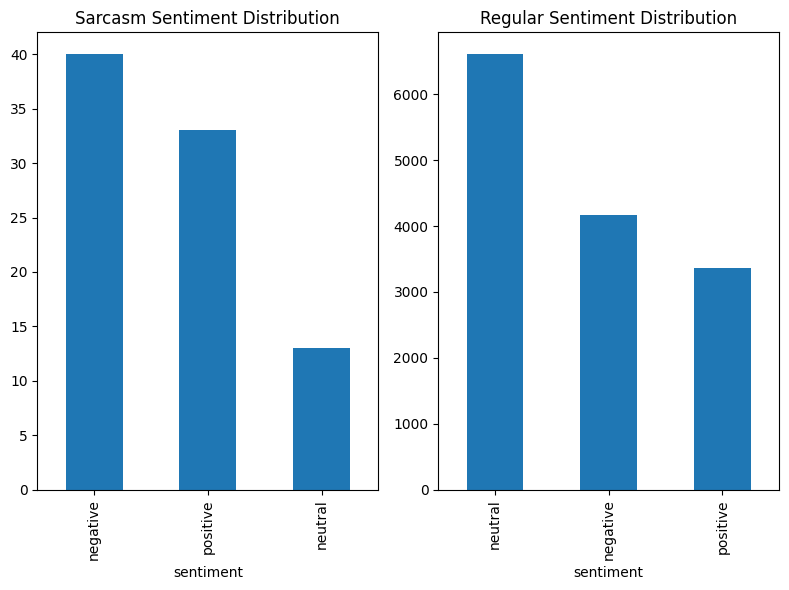

In [15]:
# Plot sentiment distribution for each dataframe
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
df_sarcasm['sentiment'].value_counts().plot(kind='bar', title='Sarcasm Sentiment Distribution')

plt.subplot(1, 3, 2)
df_regular['sentiment'].value_counts().plot(kind='bar', title='Regular Sentiment Distribution')

plt.tight_layout()
plt.show()

**Text Length Distribution**

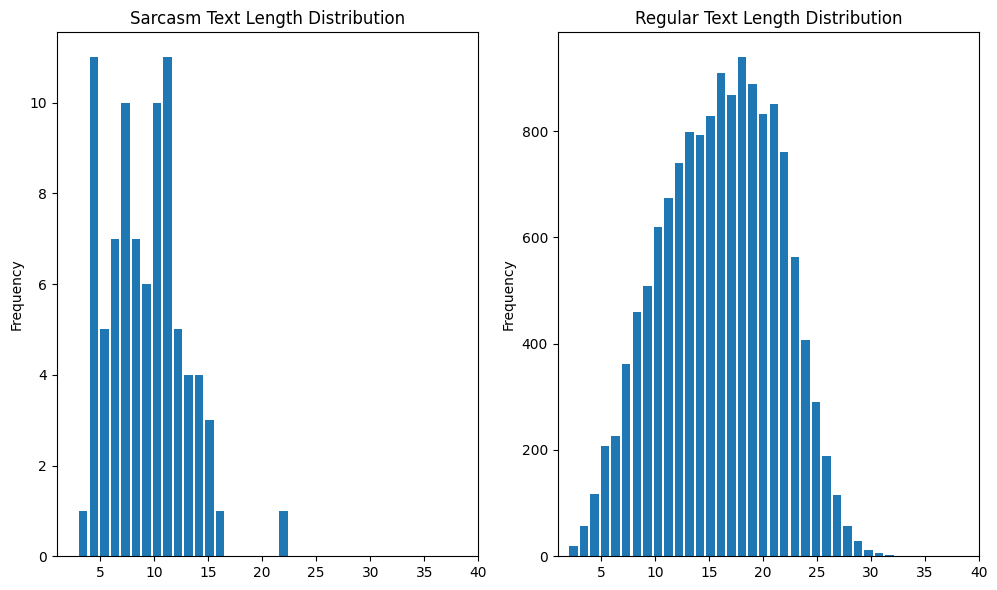

In [16]:
import matplotlib.pyplot as plt

# Create a function to calculate text length
df_sarcasm['text_length'] = df_sarcasm['text'].apply(lambda x: len(x.split()))  # Word count
df_regular['text_length'] = df_regular['text'].apply(lambda x: len(x.split()))

# Increase figure size and adjust layout
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
df_sarcasm['text_length'].plot(kind='hist', bins=40, range=(1, 40), rwidth=0.8, title='Sarcasm Text Length Distribution')
plt.xlim(1, 40)

plt.subplot(1, 3, 2)
df_regular['text_length'].plot(kind='hist', bins=40, range=(1, 40), rwidth=0.8, title='Regular Text Length Distribution')
plt.xlim(1, 40)

# Adjust the layout for more spacing between plots
plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between plots

plt.tight_layout()
plt.show()

**Word Cloud**

Word Cloud for Sarcasm:


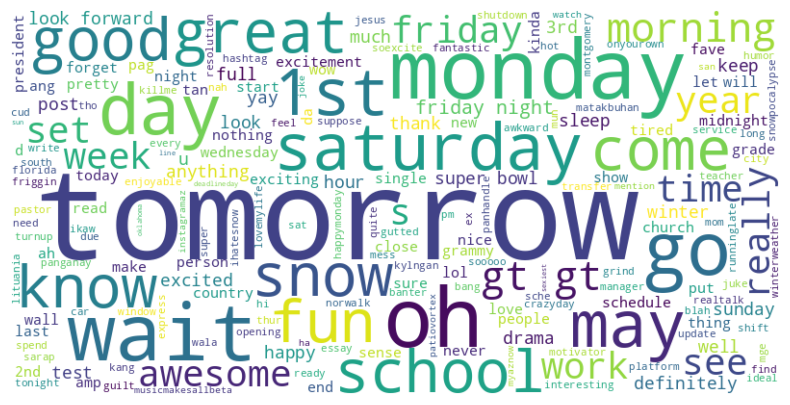


Word Cloud for Regular:


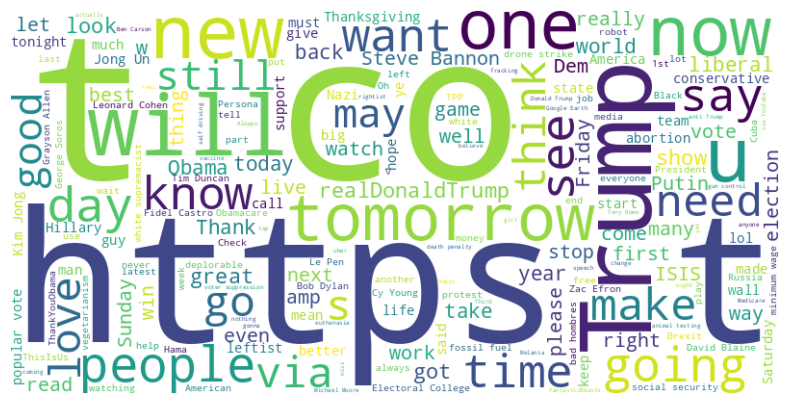

In [17]:
def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Plot word clouds for each dataset
print("Word Cloud for Sarcasm:")
plot_wordcloud(df_sarcasm['text'])
print("\nWord Cloud for Regular:")
plot_wordcloud(df_regular['text'])

**Check for Class Imbalance**

In [18]:
# Calculate and display class proportions for each dataset
print("Sarcasm dataset class proportions:")
print(df_sarcasm['label'].value_counts(normalize=True))

print("\nRegular dataset class proportions:")
print(df_regular['label'].value_counts(normalize=True))

Sarcasm dataset class proportions:
label
0    0.465116
2    0.383721
1    0.151163
Name: proportion, dtype: float64

Regular dataset class proportions:
label
1    0.467284
0    0.295254
2    0.237462
Name: proportion, dtype: float64


# **Dataset Combination, Stratified Splitting and Class Weighing**

**Dataset Combination**

In [19]:
# Add 'sarcastic' flag
df_sarcasm['sarcastic'] = 1
df_regular['sarcastic'] = 0

# Combine and shuffle
df_combined = pd.concat([df_sarcasm, df_regular], ignore_index=True)
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
print("Data overview:")
print(df_combined.head())
print("\nSentiment Distribution:\n", df_combined['label'].value_counts())
print("\nSarcasm Distribution:\n", df_combined['sarcastic'].value_counts())

Data overview:
  sentiment                                               text  label  \
0   neutral       @KremlinTrolls oh my https://t.co/a4qR2AXYOH      1   
1  negative  How The Booming Fake News Biz Proves That Libe...      0   
2   neutral  Dallas did 'Dalllas' Thursday night at premier...      1   
3  negative  Trudeau Liberals even will remove mandatory mi...      0   
4  positive  Watching the live stream of Miss Teen USA whil...      2   

   text_length  sarcastic  
0            4          0  
1           16          0  
2           17          0  
3           21          0  
4           15          0  

Sentiment Distribution:
 label
1    6619
0    4214
2    3390
Name: count, dtype: int64

Sarcasm Distribution:
 sarcastic
0    14137
1       86
Name: count, dtype: int64


**Stratified Split by Both Sentiment and Sarcasm**

In [21]:
df_combined['stratify_col'] = df_combined['label'].astype(str) + "_" + df_combined['sarcastic'].astype(str)

train_df, test_df = train_test_split(
    df_combined,
    test_size=0.3,
    stratify=df_combined['stratify_col'],
    random_state=42,
)

# Drop stratify_col after splitting
train_df = train_df.drop(columns=['stratify_col'])
test_df = test_df.drop(columns=['stratify_col'])

In [22]:
print("\nTrain Sentiment Distribution:\n", train_df['label'].value_counts())
print("Train Sarcasm Distribution:\n", train_df['sarcastic'].value_counts())
print("\nTest Sentiment Distribution:\n", test_df['label'].value_counts())
print("Test Sarcasm Distribution:\n", test_df['sarcastic'].value_counts())


Train Sentiment Distribution:
 label
1    4633
0    2950
2    2373
Name: count, dtype: int64
Train Sarcasm Distribution:
 sarcastic
0    9896
1      60
Name: count, dtype: int64

Test Sentiment Distribution:
 label
1    1986
0    1264
2    1017
Name: count, dtype: int64
Test Sarcasm Distribution:
 sarcastic
0    4241
1      26
Name: count, dtype: int64


**Compute Class Weights for Sentiment and Sarcasm**

In [23]:
# These will be used for weighted loss in model training

# Class weights for sentiment classification
sentiment_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
sentiment_class_weights = torch.tensor(sentiment_class_weights, dtype=torch.float)
print("\nSentiment Class Weights:", sentiment_class_weights)

# Class weights for sarcasm detection
sarcasm_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['sarcastic']),
    y=train_df['sarcastic']
)
sarcasm_class_weights = torch.tensor(sarcasm_class_weights, dtype=torch.float)
print("Sarcasm Class Weights:", sarcasm_class_weights)


Sentiment Class Weights: tensor([1.1250, 0.7163, 1.3985])
Sarcasm Class Weights: tensor([ 0.5030, 82.9667])


**Final Dataset**

In [24]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Display a sample
print("\nTrain Sample:\n", train_df[['text', 'label', 'sarcastic']].head())
print("\nTest Sample:\n", test_df[['text', 'label', 'sarcastic']].head())


Train Sample:
                                                 text  label  sarcastic
0  Fuck whoever made this🖕🏼 we got valentines so ...      0          0
1  @realDonaldTrump Mr. President,  I am an immig...      1          0
2  @HasneemMs about recycling - our group is glas...      1          0
3  The Eternal Son, by Rivers & Robots https://t....      1          0
4  Carlie: Imagine wine night with Ashley Graham ...      1          0

Test Sample:
                                                 text  label  sarcastic
0  "@andrewfowl then ur not watching. Was in ever...      1          0
1  Industry leaders were stunned by the election ...      0          0
2  @CasperMomNJ @lilmomma43420 @mikethenice1 @vac...      0          0
3  Don't forget our beauty editor Laura will be a...      2          0
4  @realDonaldTrump Sir, if you look into where t...      0          0


# **Tokenization and Encoding**

**Models 1 and 2**

In [25]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Define tokenization function
def tokenize_batch(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=64)

# Convert train/test DataFrames to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_batch, batched=True)
test_dataset = test_dataset.map(tokenize_batch, batched=True)

# Set the format to PyTorch tensors, include necessary columns
train_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label', 'sarcastic']
)
test_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label', 'sarcastic']
)

# Preview one tokenized example
print("Example tokenized entry:")
print(train_dataset[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/9956 [00:00<?, ? examples/s]

Map:   0%|          | 0/4267 [00:00<?, ? examples/s]

Example tokenized entry:
{'label': tensor(0), 'sarcastic': tensor(0), 'input_ids': tensor([  101,  6616,  9444,  2081,   100,  2057,  2288, 10113,  2015,  2061,
         2339,  2057,  2481,  1005,  1056,  2131,  1037,  2919,   100, 16770,
         1024,  1013,  1013,  1056,  1012,  2522,  1013,  1040,  2575,  6820,
         2860,  2487, 11263,  2102,  2549,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


**Model 3: Tokenize & Encode with HuggingFace Dataset**

In [26]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Rename labels to match what the model expects
df_multi = df_combined.rename(columns={'label': 'labels', 'sarcastic': 'sarcasm_labels'})

# Convert to HuggingFace Dataset
dataset_multi = Dataset.from_pandas(df_multi)

# Tokenization function for multi-task setup
def tokenize_function(example):
    tokens = tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )
    tokens['labels'] = example['labels']
    tokens['sarcasm_labels'] = example['sarcasm_labels']
    return tokens

# Apply tokenization
tokenized_dataset = dataset_multi.map(tokenize_function, batched=False)

Map:   0%|          | 0/14223 [00:00<?, ? examples/s]

# **Models**

## **Model 1 (Sarcasm Detection Classifier with DistilBERT)**

Define Model(DistilBERT Binary Classification for Sarcasm)

In [27]:
# Initialize DistilBERT for binary classification
sarcasm_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2  # 0 = Not Sarcastic, 1 = Sarcastic
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics Function

In [28]:
def compute_sarcasm_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Define Training Arguments

In [29]:
sarcasm_training_args = TrainingArguments(
    output_dir='./results/sarcasm_detection',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Setup Trainer

In [30]:
# Replace label column with sarcasm for this model
train_dataset_sarcasm = train_dataset.rename_column("sarcastic", "labels")
test_dataset_sarcasm = test_dataset.rename_column("sarcastic", "labels")

sarcasm_trainer = Trainer(
    model=sarcasm_model,
    args=sarcasm_training_args,
    train_dataset=train_dataset_sarcasm,
    eval_dataset=test_dataset_sarcasm,
    compute_metrics=compute_sarcasm_metrics
)

Train Model

In [31]:
# Train the sarcasm detector
sarcasm_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: akpanitorobong (akpanitorobong-coventry-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000200,0.007598,0.998125,0.818182,1.000000,0.692308
2,0.000100,0.003392,0.999531,0.961538,0.961538,0.961538
3,0.000000,0.003463,0.999297,0.941176,0.960000,0.923077


TrainOutput(global_step=1869, training_loss=0.006805707363512939, metrics={'train_runtime': 244.0814, 'train_samples_per_second': 122.369, 'train_steps_per_second': 7.657, 'total_flos': 494567032882176.0, 'train_loss': 0.006805707363512939, 'epoch': 3.0})

Evaluate the Model

In [32]:
# Evaluate performance on test set
eval_results = sarcasm_trainer.evaluate()
print("Sarcasm Detection Evaluation:", eval_results)

Sarcasm Detection Evaluation: {'eval_loss': 0.0033919282723218203, 'eval_accuracy': 0.999531286618233, 'eval_f1': 0.9615384615384616, 'eval_precision': 0.9615384615384616, 'eval_recall': 0.9615384615384616, 'eval_runtime': 7.1833, 'eval_samples_per_second': 594.016, 'eval_steps_per_second': 37.17, 'epoch': 3.0}


Save Model & Tokenizer

In [33]:
# Save the trained model and tokenizer
sarcasm_trainer.save_model('./models/sarcasm_detector')
tokenizer.save_pretrained('./models/sarcasm_detector')

('./models/sarcasm_detector/tokenizer_config.json',
 './models/sarcasm_detector/special_tokens_map.json',
 './models/sarcasm_detector/vocab.txt',
 './models/sarcasm_detector/added_tokens.json',
 './models/sarcasm_detector/tokenizer.json')

Predictions on Test Set

In [34]:
preds = sarcasm_trainer.predict(test_dataset_sarcasm)
pred_labels = preds.predictions.argmax(-1)
true_labels = preds.label_ids

print(classification_report(test_dataset_sarcasm['labels'], pred_labels, target_names=['Not Sarcastic', 'Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       1.00      1.00      1.00      4241
    Sarcastic       0.96      0.96      0.96        26

     accuracy                           1.00      4267
    macro avg       0.98      0.98      0.98      4267
 weighted avg       1.00      1.00      1.00      4267



**Visualize Confusion Matrix**

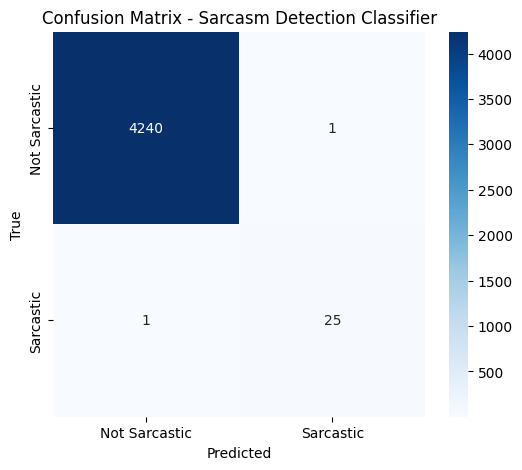

In [35]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Sarcasm Detection Classifier')
plt.show()

## **Model 2 (Baseline Sentiment Classifier with DistilBERT)**

**Initialize Model**

In [36]:
# Initialize model for 3-class sentiment classification
baseline_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3  # 0 = Negative, 1 = Neutral, 2 = Positive
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Define Metrics Function for Sentiment**

In [37]:
def compute_sentiment_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

**Define Training Arguments**

In [38]:
baseline_training_args = TrainingArguments(
    output_dir='./results/baseline_sentiment',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='f1'
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**Set Up the Trainer**

In [39]:
# Ensure the correct label column is used
train_dataset_sentiment = train_dataset.rename_column("label", "labels")
test_dataset_sentiment = test_dataset.rename_column("label", "labels")

baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_training_args,
    train_dataset=train_dataset_sentiment,
    eval_dataset=test_dataset_sentiment,
    compute_metrics=compute_sentiment_metrics
)

**Train the Model**

In [40]:
baseline_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.644400,0.652321,0.701430,0.701460,0.702755,0.701430
2,0.511700,0.658287,0.717366,0.717468,0.717886,0.717366
3,0.369600,0.755207,0.716428,0.716168,0.720282,0.716428
4,0.234600,0.901899,0.715960,0.715502,0.720723,0.715960
5,0.157500,1.007367,0.715725,0.715753,0.715879,0.715725


TrainOutput(global_step=3115, training_loss=0.4002394216975278, metrics={'train_runtime': 371.5862, 'train_samples_per_second': 133.966, 'train_steps_per_second': 8.383, 'total_flos': 824293087971840.0, 'train_loss': 0.4002394216975278, 'epoch': 5.0})

**Evaluate the Model**

In [41]:
baseline_eval_results = baseline_trainer.evaluate()
print("Baseline Sentiment Evaluation:", baseline_eval_results)

baseline_preds = baseline_trainer.predict(test_dataset_sentiment)
baseline_pred_labels = baseline_preds.predictions.argmax(-1)

print(classification_report(test_dataset_sentiment['labels'], baseline_pred_labels, target_names=['Negative', 'Neutral', 'Positive']))

Baseline Sentiment Evaluation: {'eval_loss': 0.6582872867584229, 'eval_accuracy': 0.7173658307944691, 'eval_f1': 0.7174676402979824, 'eval_precision': 0.7178860561279812, 'eval_recall': 0.7173658307944691, 'eval_runtime': 7.4824, 'eval_samples_per_second': 570.273, 'eval_steps_per_second': 35.684, 'epoch': 5.0}
              precision    recall  f1-score   support

    Negative       0.75      0.72      0.73      1264
     Neutral       0.71      0.71      0.71      1986
    Positive       0.70      0.73      0.71      1017

    accuracy                           0.72      4267
   macro avg       0.72      0.72      0.72      4267
weighted avg       0.72      0.72      0.72      4267



**Save Model & Tokenizer**

In [42]:
baseline_trainer.save_model('./models/baseline_sentiment_classifier')
tokenizer.save_pretrained('./models/baseline_sentiment_classifier')

('./models/baseline_sentiment_classifier/tokenizer_config.json',
 './models/baseline_sentiment_classifier/special_tokens_map.json',
 './models/baseline_sentiment_classifier/vocab.txt',
 './models/baseline_sentiment_classifier/added_tokens.json',
 './models/baseline_sentiment_classifier/tokenizer.json')

**Predictions on Test Set**

In [43]:
# Run inference on the test set
baseline_predictions = baseline_trainer.predict(test_dataset_sentiment)

# Extract predicted class labels (0, 1, 2)
predicted_labels = baseline_predictions.predictions.argmax(axis=-1)
true_labels = baseline_predictions.label_ids


# Classification report with class names
print("Baseline Sentiment Classifier Performance:")
print(classification_report(true_labels, predicted_labels, target_names=['Negative', 'Neutral', 'Positive']))

Baseline Sentiment Classifier Performance:
              precision    recall  f1-score   support

    Negative       0.75      0.72      0.73      1264
     Neutral       0.71      0.71      0.71      1986
    Positive       0.70      0.73      0.71      1017

    accuracy                           0.72      4267
   macro avg       0.72      0.72      0.72      4267
weighted avg       0.72      0.72      0.72      4267



**Visualize Confusion Matrix**

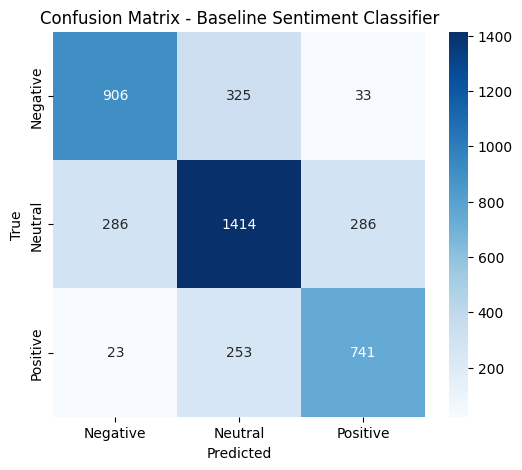

In [44]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Baseline Sentiment Classifier')
plt.show()

## **Model 3 (Sarcasm-Aware Sentiment Classifier with BERT)**

**Define Multitask Model**

In [70]:
class SarcasmAwareSentimentModel(DistilBertPreTrainedModel):
    def __init__(self, config):
        super(SarcasmAwareSentimentModel, self).__init__(config)
        self.bert = DistilBertModel(config)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Sentiment classification head (3 classes)
        self.sentiment_classifier = nn.Linear(config.dim, 3)

        # Sarcasm detection head (binary classification)
        self.sarcasm_classifier = nn.Linear(config.dim, 2)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, sarcasm_labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token embedding

        pooled_output = self.dropout(pooled_output)

        sentiment_logits = self.sentiment_classifier(pooled_output)
        sarcasm_logits = self.sarcasm_classifier(pooled_output)

        loss = None
        if labels is not None and sarcasm_labels is not None:
            loss_fct_sentiment = nn.CrossEntropyLoss()
            loss_fct_sarcasm = nn.CrossEntropyLoss()

            sentiment_loss = loss_fct_sentiment(sentiment_logits, labels)
            sarcasm_loss = loss_fct_sarcasm(sarcasm_logits, sarcasm_labels)

            # You can tune this weight later
            alpha = 0.5
            loss = sentiment_loss + alpha * sarcasm_loss

        return {
            "loss": loss,
            "logits": sentiment_logits,
            "sarcasm_logits": sarcasm_logits,
        }

**Split into Train & Test Sets (Stratified)**

In [71]:
# Stratified split
df_train, df_test = train_test_split(
    df_multi,
    test_size=0.3,
    stratify=df_multi[['labels', 'sarcasm_labels']],
    random_state=42
)

# Convert to datasets
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# Apply tokenization again
train_dataset = train_dataset.map(tokenize_function, batched=False)
test_dataset = test_dataset.map(tokenize_function, batched=False)

Map:   0%|          | 0/9956 [00:00<?, ? examples/s]

Map:   0%|          | 0/4267 [00:00<?, ? examples/s]

**Wrap the Model in a Custom Trainer**

In [72]:
class MultiTaskTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):

        # Rename inputs to match model expectations
        labels = inputs.pop("labels")
        sarcasm_labels = inputs.pop("sarcasm_labels")

        # Forward pass
        outputs = model(**inputs, labels=labels, sarcasm_labels=sarcasm_labels)
        loss = outputs["loss"]

        return (loss, outputs) if return_outputs else loss

**Define Training Arguments**

In [73]:
training_args = TrainingArguments(
    output_dir="./sarcasm_aware_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    logging_steps=10,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**Initialize Model**

In [74]:
# Initialize model config
config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
model = SarcasmAwareSentimentModel(config)

**Confusion Matrix Function**

In [75]:
def plot_confusion_matrix_tensorboard(cm, labels, tag="Confusion Matrix", step=0):
    """Plots confusion matrix and logs it as an image to TensorBoard."""
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(tag)

    # Save figure to an in-memory buffer
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)  # Add batch dimension

    # Write to TensorBoard
    writer = tf.summary.create_file_writer("runs/confusion_matrices")
    with writer.as_default():
        tf.summary.image(tag, image, step=step)

**Define Metrics**

In [76]:
def compute_metrics(eval_pred):
    (logits_sentiment, logits_sarcasm), (labels_sentiment, labels_sarcasm) = eval_pred

    preds_sentiment = logits_sentiment.argmax(-1)
    preds_sarcasm = logits_sarcasm.argmax(-1)

    # Metrics
    acc_sentiment = accuracy_score(labels_sentiment, preds_sentiment)
    acc_sarcasm = accuracy_score(labels_sarcasm, preds_sarcasm)

    precision_sentiment = precision_score(labels_sentiment, preds_sentiment, average='weighted')
    recall_sentiment = recall_score(labels_sentiment, preds_sentiment, average='weighted')
    f1_sentiment = f1_score(labels_sentiment, preds_sentiment, average='weighted')

    precision_sarcasm = precision_score(labels_sarcasm, preds_sarcasm, average='weighted')
    recall_sarcasm = recall_score(labels_sarcasm, preds_sarcasm, average='weighted')
    f1_sarcasm = f1_score(labels_sarcasm, preds_sarcasm, average='weighted')

    # Confusion matrices
    cm_sentiment = confusion_matrix(labels_sentiment, preds_sentiment)
    cm_sarcasm = confusion_matrix(labels_sarcasm, preds_sarcasm)

    # Log to TensorBoard
    plot_confusion_matrix_tensorboard(cm_sentiment, ['Negative', 'Neutral', 'Positive'], "Sentiment CM")
    plot_confusion_matrix_tensorboard(cm_sarcasm, ['Not Sarcastic', 'Sarcastic'], "Sarcasm CM")

    return {
        "accuracy_sentiment": acc_sentiment,
        "accuracy_sarcasm": acc_sarcasm,
        "precision_sentiment": precision_sentiment,
        "recall_sentiment": recall_sentiment,
        "f1_sentiment": f1_sentiment,
        "precision_sarcasm": precision_sarcasm,
        "recall_sarcasm": recall_sarcasm,
        "f1_sarcasm": f1_sarcasm
    }

In [77]:
"""def compute_metrics(eval_pred):
    (logits_sentiment, logits_sarcasm), (labels_sentiment, labels_sarcasm) = eval_pred

    preds_sentiment = logits_sentiment.argmax(-1)
    preds_sarcasm = logits_sarcasm.argmax(-1)

    acc_sentiment = accuracy_score(labels_sentiment, preds_sentiment)
    acc_sarcasm = accuracy_score(labels_sarcasm, preds_sarcasm)

    return {
        "accuracy_sentiment": acc_sentiment,
        "accuracy_sarcasm": acc_sarcasm
    }"""

'def compute_metrics(eval_pred):\n    (logits_sentiment, logits_sarcasm), (labels_sentiment, labels_sarcasm) = eval_pred\n\n    preds_sentiment = logits_sentiment.argmax(-1)\n    preds_sarcasm = logits_sarcasm.argmax(-1)\n\n    acc_sentiment = accuracy_score(labels_sentiment, preds_sentiment)\n    acc_sarcasm = accuracy_score(labels_sarcasm, preds_sarcasm)\n\n    return {\n        "accuracy_sentiment": acc_sentiment,\n        "accuracy_sarcasm": acc_sarcasm\n    }'

**Initialize Trainer**

In [78]:
train_dataset

Dataset({
    features: ['sentiment', 'text', 'labels', 'text_length', 'sarcasm_labels', 'stratify_col', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 9956
})

In [79]:
multi_task_trainer = MultiTaskTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-79-29d034dc3bff>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MultiTaskTrainer.__init__`. Use `processing_class` instead.
  multi_task_trainer = MultiTaskTrainer(


**Train the Model**

In [80]:
multi_task_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy Sentiment,Accuracy Sarcasm,Precision Sentiment,Recall Sentiment,F1 Sentiment,Precision Sarcasm,Recall Sarcasm,F1 Sarcasm
1,0.937000,0.906832,0.589173,0.993907,0.598947,0.589173,0.583441,0.987851,0.993907,0.990869
2,0.791600,0.851127,0.612140,0.993907,0.614516,0.612140,0.612288,0.987851,0.993907,0.990869
3,0.661000,0.882075,0.627139,0.993907,0.628047,0.627139,0.624998,0.987851,0.993907,0.990869


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1869, training_loss=0.8316790895579396, metrics={'train_runtime': 373.7584, 'train_samples_per_second': 79.913, 'train_steps_per_second': 5.001, 'total_flos': 975639617344512.0, 'train_loss': 0.8316790895579396, 'epoch': 3.0})